Import the Neccesary Libraries

In [1]:
# Import the neccesary libraries needed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from numpy import insert
import os
import time

# keras tuner for hyperparameter tuning
#import keras_tuner as kt

# tensorflow Libraries
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.models import load_model

Import the CSV Training and Testing Data Sets

In [2]:
# Import the csv's (IMPORTANT: You need at least 16 Gb of RAM to proceed)
train=pd.read_csv(r'C:\Users\rferr\University of Massachusetts Dartmouth\Michael R Bisbano - ECE457_Senior_Design\CSV_Files\0001_1404.038_port_FinalCleaned.csv')
test=pd.read_csv(r'C:\Users\rferr\University of Massachusetts Dartmouth\Michael R Bisbano - ECE457_Senior_Design\CSV_Files\0001_1404.038_stbd_FinalCleaned.csv')

Split up the Features and Labels from both the Training and Testing Datasets

In [3]:
# Split up the features and labels from both the training and testing datasets
x_train=train.iloc[:,3:24]
#x_train['TWTT']=train.iloc[:,28]  I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_train['Amplitude']=train.iloc[:,29]


x_test=test.iloc[:,3:24]
#x_test['TWTT']=test.iloc[:,28] I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_test['Amplitude']=test.iloc[:,29]

y_train=train.iloc[:,26]

y_test=test.iloc[:,26]

Scale the Feaures from -1 to 1 so that Training is Easier for the Model

In [4]:
# Scale the Features and Labels from [-1,1]
s1=MinMaxScaler(feature_range=(0,1))
x_train_scale=s1.fit_transform(x_train)

s2=MinMaxScaler(feature_range=(0,1))
x_test_scale=s2.fit_transform(x_test)
x_test_scale=x_test_scale

# Scale DOA's from (0 to 1)
s3=MinMaxScaler(feature_range=(0,1))
#y_train_scale = s3.fit_transform(train[['DOA']])
y_train_scale= y_train.to_numpy()

s4=MinMaxScaler(feature_range=(0,1))
#y_test_scale = s4.fit_transform(test[['DOA']])
y_test_scale= y_test.to_numpy()

print(len(x_train_scale))
print(len(y_train_scale))

3663910
3663910


Shift the DOA's to the Left by one so that the Current I and Q data Align with the current DOA while using TimeSeriesGenerator to Window the Data

In [5]:
# Shift the DOA to the left by one to use the current DOA label with the current I and Q data.
# Normally the TimeseriesGenerator function uses past values to predict the future but we would like current data to help predict the current samples' DOA
print(len(x_train_scale))
print(len(y_test_scale))
y_train_scale=insert(y_train_scale, 0, 0)
y_train_scale=np.delete(y_train_scale, -1)
y_test_scale=insert(y_test_scale, 0,0)
y_test_scale=np.delete(y_test_scale, -1)
print(y_train_scale)
print(len(y_train_scale))
print(y_test_scale)
print(len(y_test_scale))

3663910
3410591
[ 0.         -0.252      -0.64800001 ... 73.62600064 73.62600064
 73.57800064]
3663910
[ 0.          2.82000002  1.89000002 ... 76.59600067 76.35000066
 76.32600066]
3410591


Create the Windows Neccesary for the LSTM model using the TimeSeriesGenerator Function

In [6]:
# Create the windows neccesary for the LSTM model within tensorflow keras
# Below are the arguments of the timeseries_dataset_from_array function
# The function takes a numpy array and makes a timeseries out of it
NumSampsPerPing= 4297
data=x_train_scale # the data to make the windows
targets=y_train_scale # time steps in the data (don't need)
sequence_length=10 # window length
sequence_stride=1# period between successive output sequences
sampling_rate=1 # period between successive individual timesteps     within sequences
batch_size=48 # number of time series samples in each batch
shuffle=False #shuffle the data before making the windows
seed=None # is related to shuffle
start_index=None # is related to shuffle
end_index=None # is related to shuffle
n_features=21

test_data=x_test_scale
test_targets=y_test_scale

inputs=TimeseriesGenerator(data=data, targets=targets,length=sequence_length, sampling_rate=sampling_rate,stride=sequence_stride, batch_size= batch_size)
#test_inputs=TimeseriesGenerator(test_data[0:40000], -1*test_targets[0:40000],sequence_length, batch_size)
test_inputs=TimeseriesGenerator(data=test_data, targets=test_targets,length=sequence_length, sampling_rate=sampling_rate,stride=sequence_stride, batch_size= batch_size)
#inputs=tf.keras.preprocessing.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride, sampling_rate, batch_size, shuffle)
#print(type(inputs))

print('done')

done


Define the Model's Structure

In [40]:
# With all the preproccessing done, it is time to define the model
# Define the LSTM Model
model= Sequential()
model.add(LSTM(units=1, activation='tanh', input_shape=(sequence_length,n_features), return_sequences=False))
#model.add(Dense(units=300))
#model.add(Dropout(0.5))

#model.add(LSTM(units=416, activation='tanh', return_sequences=True))
#model.add(Dense(units=300))
#model.add(Dropout(0.5))

#model.add(LSTM(units=512, return_sequences=True))
#model.add(Dense(units=300))
#model.add(Dropout(0.5))

#model.add(LSTM(units=416, return_sequences=False))
#model.add(Dense(units=300))
#model.add(Dropout(0.5))

#model.add(LSTM(units=64, return_sequences=False))
#model.add(Dense(units=60))
#model.add(Dropout(0.2))

#model.add(LSTM(units=320, activation='tanh', return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(units=480))
#model.add(Dropout(0.2))
model.add(Dense(units=400))
model.add(Dense(units=300))
model.add(Dense(units=200))
model.add(Dense(units=100))
model.add(Dense(units=50))

model.add(Dense(units=1)) #one output (namely: DOA)


In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1)                 92        
                                                                 
 dense_18 (Dense)            (None, 400)               800       
                                                                 
 dense_19 (Dense)            (None, 300)               120300    
                                                                 
 dense_20 (Dense)            (None, 200)               60200     
                                                                 
 dense_21 (Dense)            (None, 100)               20100     
                                                                 
 dense_22 (Dense)            (None, 50)                5050      
                                                                 
 dense_23 (Dense)            (None, 1)                

Train the Model using the Specified Hyperparmeters

In [42]:
def scheduler(epoch,lr):
    if epoch<=1:
        return lr
    elif epoch>=2 | epoch<=4:
        return lr/1.15
    else:
        return lr * tf.math.exp(-.5)


76332/76332 [==============================] - 330s 4ms/step - loss: 11.9592


Text(0, 0.5, 'loss')

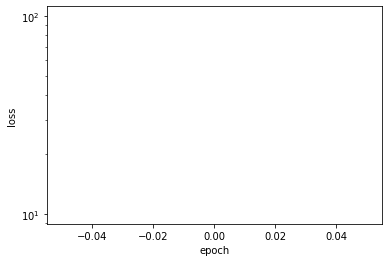

In [43]:
#Now it is time to train the model
opt=tf.keras.optimizers.Adam(learning_rate=.005)#,decay=.97)
huber=tf.keras.losses.Huber(delta=8)
model.compile(loss=huber, optimizer=opt)#metrics=['mean_squared_error','binary_crossentropy'])


sc = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Allow for early stopping so that the model does not overfit the training dataset
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)

#t0=time.time()
#history= model.fit(inputs,steps_per_epoch=4000,epochs=200,verbose=1, callbacks=[es])
history= model.fit(inputs,epochs=1,batch_size=None)
#t1=time.time()
#print("The total run time to train was %.2f seconds"%(t1-t0))

# plot the loss function
plt.figure()
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')


Using the Model, Predict the DOA's on the Testing Dataset

In [44]:
#use the model to predict on the testing dataset
#for right now test_inputs has only the 40,001 samples
predicted=model.predict(test_inputs, verbose=1)

71054/71054 [==============================] - 98s 1ms/step


In [45]:
print(predicted[10:21])

[[20.4012  ]
 [20.394495]
 [20.392548]
 [20.400024]
 [20.40403 ]
 [20.399754]
 [20.408611]
 [20.402035]
 [20.400265]
 [20.406696]
 [20.41312 ]]


In [46]:
print(y_test[10:21])

10    12.336
11     0.198
12    -6.234
13     9.186
14     8.934
15     2.952
16    -6.834
17     8.796
18    12.750
19    10.566
20     9.384
Name: DOA, dtype: float64


In [47]:
type(predicted)
predicted.shape

(3410581, 1)

In [48]:
predicted_reshape= predicted.reshape(len(predicted),1)

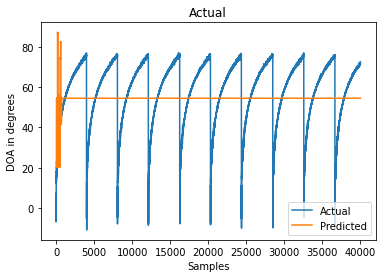

In [49]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted_reshape[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()



Compare the Actual Testing DOA's to the Predicted DOA's

Put the predicted DOA's back into a csv file format

In [34]:
#Ping |  Num Samp Num | PORT or STBD (0 or 1) |  TWTT |  Predicted DOA   <=======Output columns.
OutputCSVdf=test.iloc[:,[0,1,2,3]]
#OutputCSVdf= pd.DataFrame(test.iloc[:,[0,1,2,3]], columns=['PingNumber','SampNumber','PortStbd', 'SampleTime'])
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted)
Predicteddf= pd.DataFrame(predictedShifted,columns=['PredictedDOA'])
OutputCSVdf=OutputCSVdf.join(Predicteddf)

In [35]:
test.iloc[:,[0,1,2,3]]

,PingNum,SampleNum,PortStbd,SampleTimeDelay
0,130694,2078,1,0.031901
1,130694,2079,1,0.031916
2,130694,2080,1,0.031931
3,130694,2081,1,0.031947
4,130694,2083,1,0.031977
...,...,...,...,...
3410586,131577,6473,1,0.099403
3410587,131577,6474,1,0.099419
3410588,131577,6475,1,0.099434
3410589,131577,6476,1,0.099450


In [36]:
zerosArray= np.arange(sequence_length)*0
zerosArray

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
predictedShifted=np.append(zerosArray, predicted)
predictedShifted

array([ 0.        ,  0.        ,  0.        , ..., 73.9360199 ,
       73.9463501 , 73.95057678])

In [38]:
OutputCSVdf

,PingNum,SampleNum,PortStbd,SampleTimeDelay,PredictedDOA
0,130694,2078,1,0.031901,0.000000
1,130694,2079,1,0.031916,0.000000
2,130694,2080,1,0.031931,0.000000
3,130694,2081,1,0.031947,0.000000
4,130694,2083,1,0.031977,0.000000
...,...,...,...,...,...
3410586,131577,6473,1,0.099403,73.908386
3410587,131577,6474,1,0.099419,73.922142
3410588,131577,6475,1,0.099434,73.936020
3410589,131577,6476,1,0.099450,73.946350


In [39]:
OutputCSVdf.to_csv(path_or_buf="C:\\Users\\rferr\\Desktop\\CSVs\\PredictedOutputTest_NEW_DATA_1.csv")

In [136]:
tf.keras.models.save_model(model,filepath="C:\\Users\\rferr\\Desktop\\CSVs\\model_Percent.h5")